In [64]:
#Trading packages
import talib
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol,  \
    schedule_function, date_rules, time_rules, commission
import pyfolio as pf

#General datahandling and computation
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

In [65]:
%load_ext zipline
%matplotlib inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


# Implementing MACD for FAANG

Start date,2006-01-03
End date,2012-12-31
Total months,83
,Backtest
Annual return,2.7%
Cumulative returns,20.2%
Annual volatility,22.5%
Sharpe ratio,0.23
Calmar ratio,0.05
Stability,0.00
Max drawdown,-57.8%


/Users/oscarengelbrektson/anaconda/envs/zipline_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,57.81,2007-10-31,2009-03-09,NaT,NaN
1,10.11,2007-07-19,2007-08-16,2007-10-29,73
2,7.69,2006-05-10,2006-07-17,2006-09-12,90
3,6.16,2007-02-22,2007-03-05,2007-04-20,42
4,3.87,2006-01-11,2006-01-20,2006-02-15,26


/Users/oscarengelbrektson/anaconda/envs/zipline_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


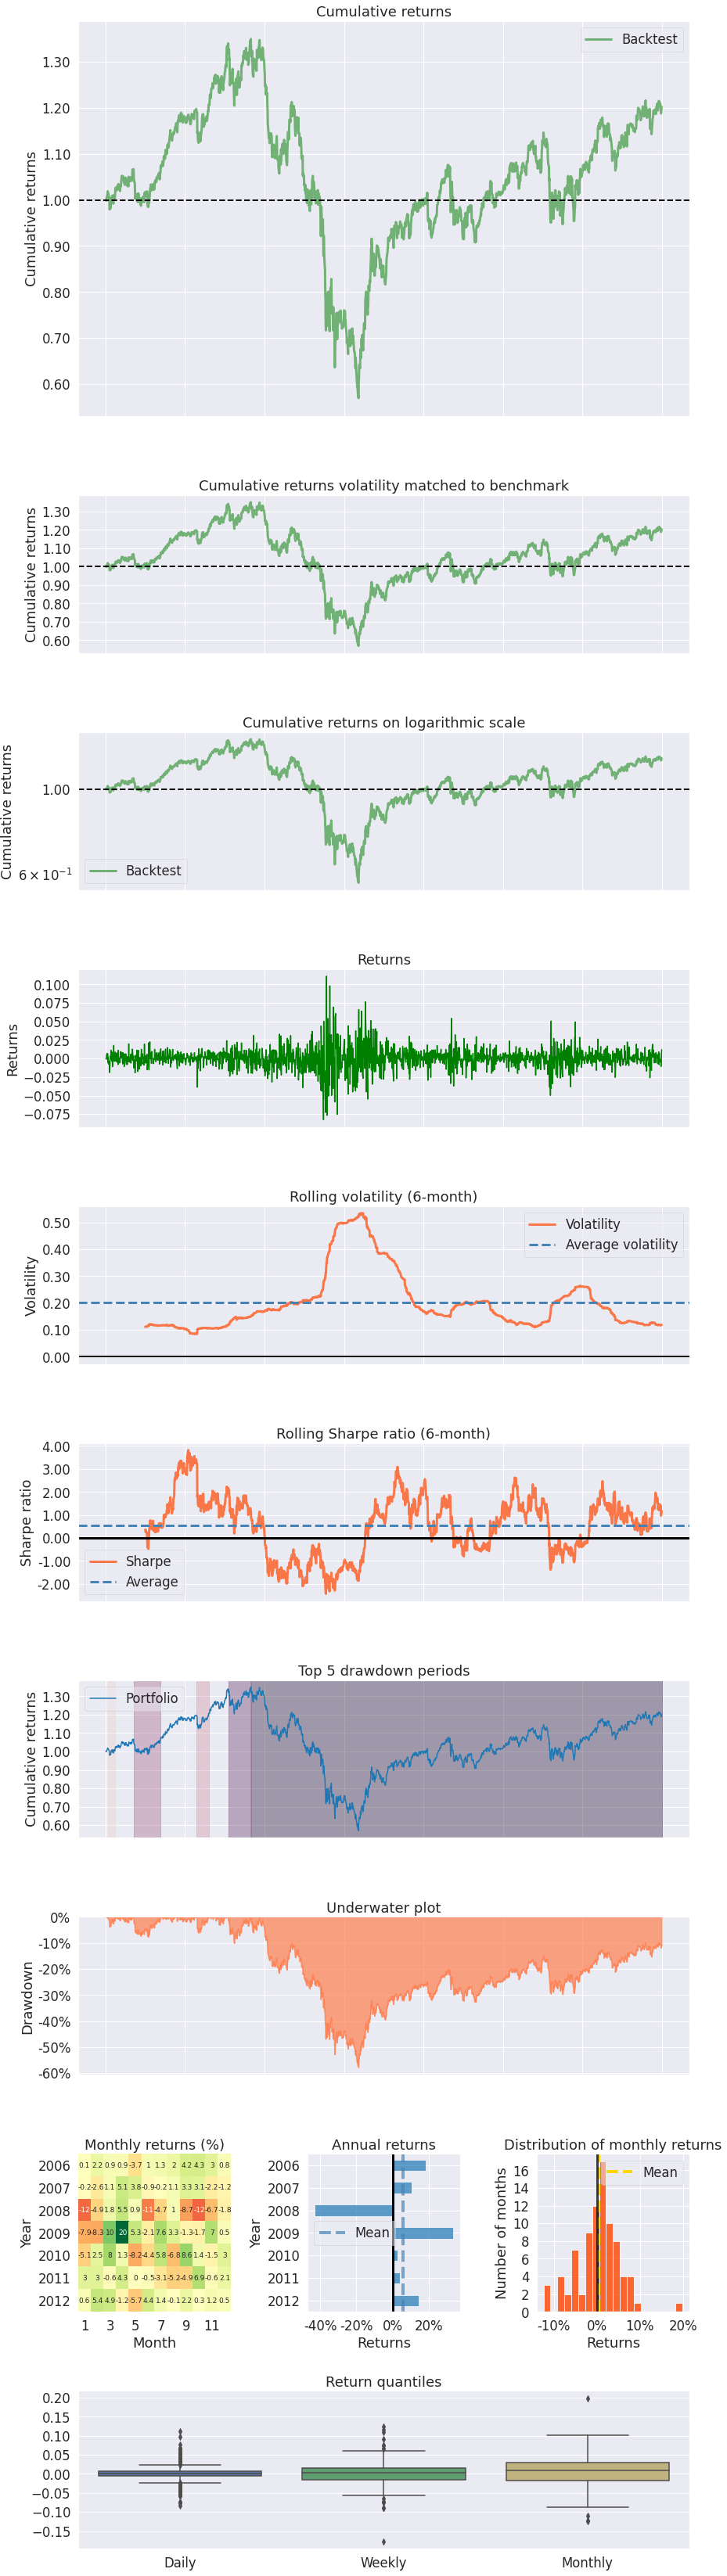

In [46]:
def initialize(context):
    # FAANG: Which stocks to trade
    symbols = [
        "FB",
        "AAPL",
        "AMZN",
        "NFLX",
        "GOOGL"
    ]
    
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in symbols]
    
    #Parameters for MACD
    context.slow_ema = 26
    context.fast_ema = 12
    context.signal_ema = 9
    
    #Commision
    #context.set_commission(us_equities=True)
    
    context.has_position=False


def handle_data(context, data):
    
    for stock in context.universe:
        hist = data.history(stock, fields="close", frequency="1d", bar_count=1)

        #Compute macd
        macd, macdsignal, macdhist = talib.MACD(hist, 
                                                fastperiod=context.fast_ema, 
                                                slowperiod=context.slow_ema, 
                                                signalperiod=context.signal_ema)

        #Buy if macd crosses above macdsignal
        if (macdhist[-1] < 0) and (not context.has_position):
            #Let's allocate capital uniformly accross FAANG stocks
            order_target_percent(stock, 1/len(context.universe))
            context.has_position=True


        #Sell if macd crosses below macdsignal
        if (macdhist[-1] > 0) and (context.has_position):
            order_target_percent(stock, 0)
            context.has_position=False

        
'''
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    #Set weight to be proportional to relative contribution to total cumulative returns
    weight_list = np.array(buy_list) / np.array(buy_list).sum()
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        #stock_weight = weight_list[num]

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)     


'''
def analyze(context, perf):
    # Use PyFolio to generate a performance report
    
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

    
    
# Fire off the backtest
start_date = pd.Timestamp(datetime(2015, 1, 1, tzinfo=pytz.UTC))
end_date = pd.Timestamp(datetime(2018, 12, 31, tzinfo=pytz.UTC))

result = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize,
    analyze=analyze, 
    capital_base=10000,
    data_frequency = 'daily', 
    bundle='quantopian-quandl' 
)

The strategy averaged 2.7% annual returns. From the cumulative returns plot we can see that the strategy generated quite strong positive returns before and after the financial crisis, but also lost 50% of the portfolio during the financial crisis. The strategy has an average sharpe ratio of less than 1, which is unimpressive and the drawdown caused by the financial crisis lasted several years. All in all, not great, although the circumstances where extraordinary.

Note that the data is from 2006 - 2012, thus including the financial crisis. However, I did clearly specify the start and end dates as 2015 and 2018, respectively. This issue persists even if I re-run the cell.

# Combining ADX and Parametric SAR to trade


ADX measures the strength of a trend, but not its direction.
SAR indicates the direction of a trend, but not its strength. As such, it can be a very volatile indicator is the trend is not strong.
The strategy then, is to trade based on SAR, only in cases where the trend is strong, as measured by ADX.

In [111]:
def initialize(context):
    # Which stocks to trade
    symbols = [
        "FB",
        "AAPL",
        "AMZN",
        "NFLX",
        "GOOGL"
    ]
    
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in symbols]
        
    context.has_position=False


def handle_data(context, data):
    '''
    ADX measures the strength of a trend, but not its direction.
    SAR indicates the direction of a trend, but not its strength. As such, it can be a very volatile indicator is the trend is not strong.
    The strategy then, is to trade based on SAR, only in cases where the trend is strong, as measured by ADX.
    '''
    
    for stock in context.universe:
        hist = data.history(stock, fields=["close", "high", "low"], frequency="1d", bar_count=30)
        
        #Compute metrics
        sar = talib.SAR(hist.high, hist.low)
        adx = talib.ADX(hist.high, hist.low, hist.close, timeperiod=14)
        
        
        #Buy if sar > price and adx is greater than 18
        if (sar[-1] > hist.close[-1]) and (adx[-1] > 18) and (not context.has_position):
            
            #Let's allocate capital uniformly accross FAANG stocks
            order_target_percent(stock, 1/len(context.universe))
            context.has_position=True


        #Sell if sar < price and adx is greater than 18
        if (sar[-1] < hist.close[-1]) and (adx[-1] > 18) and (context.has_position):
            order_target_percent(stock, 0)
            context.has_position=False

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
    
# Fire off the backtest
start_date = pd.Timestamp(datetime(2015, 1, 1, tzinfo=pytz.UTC))
end_date = pd.Timestamp(datetime(2018, 12, 31, tzinfo=pytz.UTC))

result = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize,
    handle_data=handle_data,
    #analyze=analyze,
    benchmark_returns=None,
    capital_base=10000, 
    data_frequency = 'daily', 
    bundle='quantopian-quandl'
)

26.16518143960907 42.20817416448339
557.5289474522895 29.820646025265052
246.09141351445362 42.03285104427537
84.39991373125312 19.1083712288592
687.6936740583734 47.31926712872339
26.212527221610827 41.84889315187943
559.7541471573247 30.51201696382397
246.70368504297375 39.683126563613435
84.74761166228761 18.632094736555953
690.9180307441447 43.32184120158832
26.27363438874517 37.186594411359586
558.0155991422266 29.21528851685974
247.59764901154134 34.010676321383734
85.07415994842331 17.196489225617505
691.1451666480044 47.556948698376836
26.465641497948802 35.950080035781184
557.1411743700363 30.404275162582277
248.56381128447882 31.794579175141354
85.12572763348541 18.57657929186041
692.5134138204181 47.468994034274296
26.695847687450147 26.931525652890162
553.8618612039764 40.0164076766458
248.70017909341038 27.213699766639866
84.96688536038195 27.06321659788372
693.0191206531103 54.28525291694763
26.918843876076345 25.769169114567845
551.7240900229967 38.34956831737511
249.484

775.6368671663806 63.9227218099428
29.2343673361047 56.54438227992775
454.74240609301415 26.00847887293969
268.4227041249996 14.051990637221715
180.55347922820118 23.739908109011292
776.9154596185111 61.19303369098976
29.142409723334747 44.902159654943254
453.2680525785315 25.971239105385127
264.83141682498064 14.41080860841653
180.7157454718139 27.42608480205175
778.6216113685844 63.53366072933534
29.109398006215425 43.665609467780286
452.3991357895108 20.811080415934786
263.60046691528254 14.757297383421255
180.93040191866228 23.73807968083214
786.1901442320515 55.2432580148322
28.053795958710204 31.087013467993
451.18884187894747 16.607974587273315
263.2367827531664 17.36928776160542
181.06637924271016 21.73398069608777
785.4980500421133 52.62738845066506
28.068071042848135 31.426569512597478
450.29463949225186 20.199207023229906
264.06285556618707 16.65626907142104
183.2932047925375 17.71090979646998
788.4249259041823 49.180558315647765
28.13982336372665 37.5335532687306
451.458339

27.329318534298636 16.581288141041668
421.94518820360423 19.457210022204926
262.437761851174 11.164420401064922
178.02288077707453 55.286731829884666
804.4494822942416 47.48636390171344
27.40235983428578 14.010873363902503
423.4203915477147 15.765031647585323
262.66507449335296 12.674885034792934
180.19446544970285 55.67447597292561
808.950192146158 46.13239973586341
27.40842452920365 16.459125257848132
424.2342115979492 15.268385218222468
263.427694011959 14.968152110049806
182.8574244329682 53.94798115611999
814.5260831806406 47.27008053260675
27.393606725923323 18.332797750009394
424.6059147093142 16.155477140510417
263.804950011959 14.770661097312962
185.7583911915889 51.71305846085943
818.8993797323648 48.77860977589643
27.13039838746713 19.235559432973627
424.0133148322294 19.21385897322841
263.08215868703985 15.744063931314855
188.70012425332686 48.60462481726355
823.7424202840888 52.708722669900304
27.136180269257057 18.890095845467357
425.1050363888484 17.35823599760519
262.75

24.688536760902906 41.01823474663379
415.18788295368506 18.04780660054512
283.118767535893 42.34372399465968
232.26902397718567 35.69878086885494
897.0672881596205 20.25487587874012
24.888492622971874 40.16176108324217
415.0005457198684 16.794096749413665
284.00418339796204 39.205911363613346
233.73557262993708 33.25954232521409
898.9816350358083 18.315737752933003
25.121510999322773 38.49854909797346
414.3643361536205 13.301207561614362
284.4706146509276 38.348609836640016
234.9135681588222 27.656707365328373
899.9416810107748 18.123807437901053
25.00450142941074 51.2163403952639
413.40783470176314 11.84713127998159
284.94192502982696 50.23352975158023
235.84368199441468 35.919820699959764
898.6549480401288 21.587941930349103
25.215661158316216 54.41121923980876
412.68653226505876 18.30062221075377
285.3958978767235 54.3796465460976
236.28372961017843 43.71637525317593
896.1945655554299 21.56261866778303
25.414751779250732 71.40897699918928
411.3973079971016 32.58269474263707
286.6013

289.37555095410187 55.53583905012875
875.9625229740203 17.93011530426978
42.01518801466927 52.38567397579015
486.3662290062401 24.47396975900813
295.1548884260784 40.21315658799423
290.02924844558464 54.68762470524075
876.2325858198133 16.18043030462108
42.36763590527395 45.95713585402287
484.92926603036955 23.14959937399391
296.2763534026301 38.510291302357786
290.69001082326076 52.61443239374154
876.0624346528725 13.39642644093376
42.843494274437774 41.52385847349245
483.34269532654724 27.153513547499372
297.34930243987145 43.816812339110534
293.6663535207129 45.58151131804652
876.345915044641 15.185510928394363
43.32037093837264 53.89045115875049
478.75238002159847 17.79585868614218
297.9235770441112 57.95766243037237
295.8178452853571 44.07888392923501
875.9914691552908 32.1975103911735
43.774498792941685 52.06207961817301
475.8554807815612 16.04598770371992
299.2032051030602 55.50989672383535
299.3700437241447 43.03930390276412
876.327214258739 30.602449527296457
44.34480713070628

339.1209453502075 40.69176172888875
1030.2608414283654 32.913319741989994
47.92462506867263 32.92066893256879
526.4347274866063 45.35160442884643
367.68076672175545 30.519079280275246
342.4406953098461 36.52798888238885
1032.5676880137898 34.31784441769765
47.25043182154938 28.583135492589548
528.745773445227 45.39390279923334
368.00527922154424 33.39365737993193
343.0358533677772 33.769329385519995
1034.0956207016036 37.572893485438634
47.27369135515606 27.462875587843218
530.9984814741098 44.61209172699773
369.4140310703787 33.233771515023925
344.6756202953358 30.610365141310734
1036.1515525125828 42.32751693732205
47.32748552448912 28.04857884492013
532.586400974689 46.855549612662145
370.0147114537718 31.266022106616344
345.16278181533806 29.59160759897729
1037.688775040914 42.70978309067419
47.27596642530637 26.56666306300549
533.4553084247171 54.071296037323634
371.79578990923835 53.047106556593896
345.4348466107452 42.958012035051034
1037.2118639678106 49.71015929442242
47.13075

1121.4065445644587 14.354743502121202
57.63883394308371 30.706322685267526
527.4821944819815 15.086612153063882
389.40517717281136 41.5186869477206
362.1126264755523 47.31495415010526
1121.919884126964 14.979438717121354
58.22251892213875 31.074226120880056
529.658484832259 14.166968297991646
388.02698158660445 39.766989038907404
365.4099007736488 48.333520885140835
1125.1877945393992 15.038122427172373
58.731993035223326 29.193716155384845
531.1366369288942 18.750788374394215
386.1987195176389 38.91459050066695
376.1420423580712 62.488948173499104
1128.9726486999698 14.642289831823996
59.15802062143022 31.436990278176122
531.0255066577771 17.98605980681101
384.1399624086734 35.73340375380685
371.4784486391471 62.699245105392684
1130.4040549192375 13.213448779357714
59.61971027660264 34.52631031960336
530.1751134619614 12.432699889993946
382.7951611838458 38.5048867036625
376.1501245012161 62.0717427543266
1133.334481126134 12.583898746237708
60.15331882832677 30.946910168400493
530.36

358.3823218681262 34.01236800745932
569.6318957770839 31.33938432640937
61.71954730300918 17.00571671169718
537.9388155190538 43.99331593324939
336.16185154846966 33.686263594992965
358.74929778458926 31.440562391733412
568.6400156552023 29.102381165657093
60.5401433845275 12.129728476344985
533.0991510760473 43.11794367544261
331.27413061046275 26.66032361672897
358.8756547205697 27.503377580622608
562.6326963280245 23.61691643637271
60.961853545656815 13.028774730445994
534.1376772359474 41.50323064622625
332.06790223900845 30.837548209695957
357.0726273025619 24.07122931314808
562.5966958899113 25.292218606355263
61.085220184757475 13.447404165802169
535.922822833458 41.06590835904107
330.6289974477256 30.595957822307895
356.3334267861657 22.009443231097695
561.0501954761182 23.992365789647106
61.16462621383474 16.394879070908775
537.6004285438028 40.201890590693296
330.10309800526267 30.96801113058811
356.8967411766492 20.553691736771345
559.6652138209458 24.13867330003046
61.20324

63.92151950780213 25.452014514177062
92.20593595417888 25.388503335599456
323.259024431043 42.365443621868195
433.6655684109513 27.40078371463129
564.795743299224 29.70422124171306
63.93606488711247 25.329638073757838
92.50846826485989 25.978889506856913
323.9649724745092 41.79661245329195
435.1595942572645 29.756984668263627
565.2284063292665 34.34740008650963
64.02884060021593 21.024759986357036
92.88445717849032 24.526138507130582
324.8419360407883 26.369232315434278
438.145462214286 25.351672944776595
567.5418465823079 27.92167783605662
63.941836661126274 22.332695042267556
93.06718131642138 21.508830283110555
331.87178775620526 25.190265872062778
439.80866158856287 21.31355895764636
568.6689286144183 23.73859701309524
63.9554362982572 21.52332591355314
93.17959786814552 15.954133539672725
332.1154116232564 25.368746070482185
441.2916596125306 27.49534485242511
569.9830658566228 20.235575230757195
64.8241097962678 15.47959272911312
93.28941222023137 14.133700651433786
332.465808607

97.92576481903626 34.35616863959289
332.83909529387125 31.618609252899727
467.7679870656195 36.97695524174292
584.9644519360012 16.844767103831966
74.33169746474606 25.618532493174786
98.08886344814425 28.470518963451966
332.7950337848001 27.841045571022605
469.7372635829693 41.32525548495866
584.9863157966348 24.518189552367133
74.49339753245037 21.218433710356035
98.14177351035033 24.042992761333924
335.96613081681227 24.477372105130623
470.3040601708636 38.19264992129421
586.1126506121498 15.587295580333752
74.482818640272 18.963762180189658
98.26506280897884 24.36145107202404
335.7871139431596 23.077248873409914
470.95132236011864 34.48034078612301
587.2096915243676 13.363599242083966
74.50102984879668 20.847018425058934
98.21354683036043 22.139035982777433
335.8624883016659 20.39239886373579
471.35149944657445 32.09499320086967
586.9276185647631 11.278536242096314
74.70284031730897 18.331698896677405
98.4325629828105 18.620151091010325
337.45229183267764 20.793531095692714
474.656

548.0416025279674 21.557633681930685
77.59925283522396 16.535656885244258
106.93457962253623 90.09508396855448
306.3128329418818 27.999502840315106
376.3227915418467 29.54781264569982
548.9116121607242 20.25587435907151
77.76077763405871 25.819477141720366
108.30653141618964 85.10711326129312
307.2842729907494 23.758800379286054
376.39894314533433 28.545166128183936
552.206530569435 15.61770238270998
77.7194044999346 31.632644356164082
109.08841865644656 79.66976816593326
307.5100949565275 20.8400628957519
378.00087371502457 28.799592316184327
554.3144966468516 13.31258351667059
77.65325204137677 35.17395508587895
109.72290964757863 74.48410922793734
308.8062703316836 20.207714526900727
381.90704761952423 28.94946131737832
556.2401492875084 17.716288016512976
77.4874326187613 34.14029416618754
110.5869254227712 69.61267870747584
305.18251302910704 54.230586518592816
380.5011855505587 29.851918470642303
555.6736594124569 18.371079712261835
76.81160197843712 31.72200404815427
110.8220814

522.8734437624106 11.028521338296711
77.31431705039611 31.19535856490886
109.680324323441 18.18672915768664
309.6065101170176 30.370192124953622
371.00293113313893 56.028234051717696
521.9785547286799 10.488663428669533
77.43465102925548 30.219994788829315
109.78926509383261 28.40217559493757
311.18430633550463 32.81915850078097
371.1411071459444 54.173578694108016
521.0670788889523 12.203703189539683
77.4192368435621 26.6167862568136
109.97324242915279 37.11080551930697
311.4668747764774 38.39809073721739
373.1189353987456 62.72047432324995
519.0425468939601 16.902834383061087
76.79931510344004 20.09252811847764
110.87811865773132 41.4054032601232
311.20328125060246 49.076368942132824
377.29215380168523 71.44809200303125
517.6115396048111 24.567832453222753
76.76913021516417 19.25428479607371
111.84632168405409 43.13206295763442
313.9369328782985 50.85631515719399
382.3476165878921 71.13360194501882
508.4440960735293 27.17446733397762
76.70437600826762 25.384268678116012
112.835795871

556.5298572678469 18.28935270762729
82.11436108507543 21.10454837597897
125.00895700307667 11.972317799503232
373.4990653441647 38.08410878749501
440.70497250166005 56.26185709092348
556.1032316211049 18.322729221222804
82.59465429504853 13.843894395564412
126.0921215552365 9.606206833196163
373.88146657389154 38.977481504778126
443.4538955743511 60.7578643915227
556.1068056222005 18.443684689800275
82.91662836221299 8.777524229138058
126.14901876209994 15.25493497765713
374.64454297904865 46.55014109186658
447.302610125235 63.838243783941486
555.2219833962143 24.77118879302813
83.34320927626 12.33318646430673
126.40903328023083 14.461244625934704
376.4735126897148 45.739010633127265
452.590717679227 63.98401809809078
555.8534718712775 24.257072149650966
83.58739847755902 24.573095035492162
126.19734256931821 11.265872892603833
377.6050261605633 43.562941379533605
457.24106821892155 64.38714239972556
556.9067126988638 22.61758057001798
83.63614069350385 28.634424777581344
126.552231672

81.59597273012373 35.90216085199392
129.5760906972649 35.78828487664999
431.0205424674118 17.402338464145107
652.510872630948 42.799905962901875
552.41649668568 14.429410568937236
81.93255988874444 34.67847734049955
129.51914656393336 36.761203015655774
431.6853483684535 15.777677361004281
654.994053429116 41.27048107776886
552.8562871779174 13.324371246541972
82.18879124902027 42.6653630892875
129.25449315539413 33.6882775618053
431.71903195466035 14.04411869182555
655.4898834070468 39.815915304003376
552.2416113158483 14.685146457399595
82.36295101773753 41.72867578798918
129.15457525383056 34.989468150385626
431.7122388512121 14.668450565858477
654.7018590854132 44.86848894136737
551.7895240634346 15.049969307995648
82.68880758557198 39.616082816467475
128.88614638085141 32.62443420813689
431.75611747190175 14.94767331874201
655.7130121888613 43.7715843467289
551.7823105769146 16.982665466178478
83.10390626695131 36.21768793328523
128.53270086758246 34.36087498206331
432.20676094842

110.8870273144538 54.32896649990124
520.1848098720197 38.8849989992568
106.86139566567846 29.89267543474465
664.6570035187224 24.873829651906757
88.02563911206713 42.29763724700337
110.23628922712867 52.28979117560866
519.7782250502268 40.09051106370381
108.22991701697676 30.820849020436828
671.9637105737155 19.11627304586369
87.38062213916092 40.29797160071784
109.68225746989286 47.48468992621496
516.8300108499509 35.51956158067454
107.18233704819345 31.58095867808035
669.7609839530259 15.48906601028129
87.13369522630595 38.729154067583615
108.43593512256197 40.75701019558155
514.2247267787122 31.864014225477423
106.30406703193303 45.28866881977975
668.3841036771637 15.043512106407462
86.68420361596964 43.40757536175488
107.53724050245683 36.038138898141945
511.8121317184106 29.356478445611202
109.07390448882384 56.11829246722413
666.1794443668188 18.293089883852527
86.48104192150937 47.16837860867844
107.64234664154634 34.72689549619168
509.863788491603 24.60033855772942
107.87541185

594.5106316200074 51.49915282795706
105.58809734004066 12.837834330209782
694.5621947802724 41.73407336831847
101.72660203194165 40.504793609669086
114.87352020863037 28.609512267370203
597.2104440237565 52.67772148413311
105.1716758007731 13.50964517296615
697.4621551933503 40.55872383008316
102.4561236953881 35.4491253901762
114.88854651114634 24.099017334019123
599.3482196662301 48.69945434338083
104.72158313203589 35.4485339535698
700.1655897353306 37.838086533840475
103.0336243067677 29.731384554127782
114.97383838469116 20.53670285898347
597.9275328357626 44.889900367548535
103.71827216415319 36.317004243431
702.6387109239975 35.37673729741304
103.62254471782765 23.764810393872633
115.04240491138371 18.979192274410632
600.4055526181954 40.95262505846322
104.55571427934989 42.30429618246384
704.8886250183 32.26215565871721
103.65288954541383 19.932456007376654
115.0623622789947 12.959383121131637
601.9803293693308 47.78539751992321
105.55338650960313 40.45842624808832
706.80747927

Start date,2013-01-02
End date,2015-12-31
Total months,36
,Backtest
Annual return,16.4%
Cumulative returns,57.8%
Annual volatility,11.8%
Sharpe ratio,1.35
Calmar ratio,1.54
Stability,0.95
Max drawdown,-10.7%


/Users/oscarengelbrektson/anaconda/envs/zipline_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.66,2014-03-05,2014-05-08,2014-08-18,119
1,6.88,2015-07-16,2015-08-24,2015-10-30,77
2,4.68,2013-01-23,2013-06-27,2013-07-12,123
3,4.34,2014-11-28,2014-12-16,2015-02-25,64
4,4.32,2014-09-19,2014-10-17,2014-11-14,41


/Users/oscarengelbrektson/anaconda/envs/zipline_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


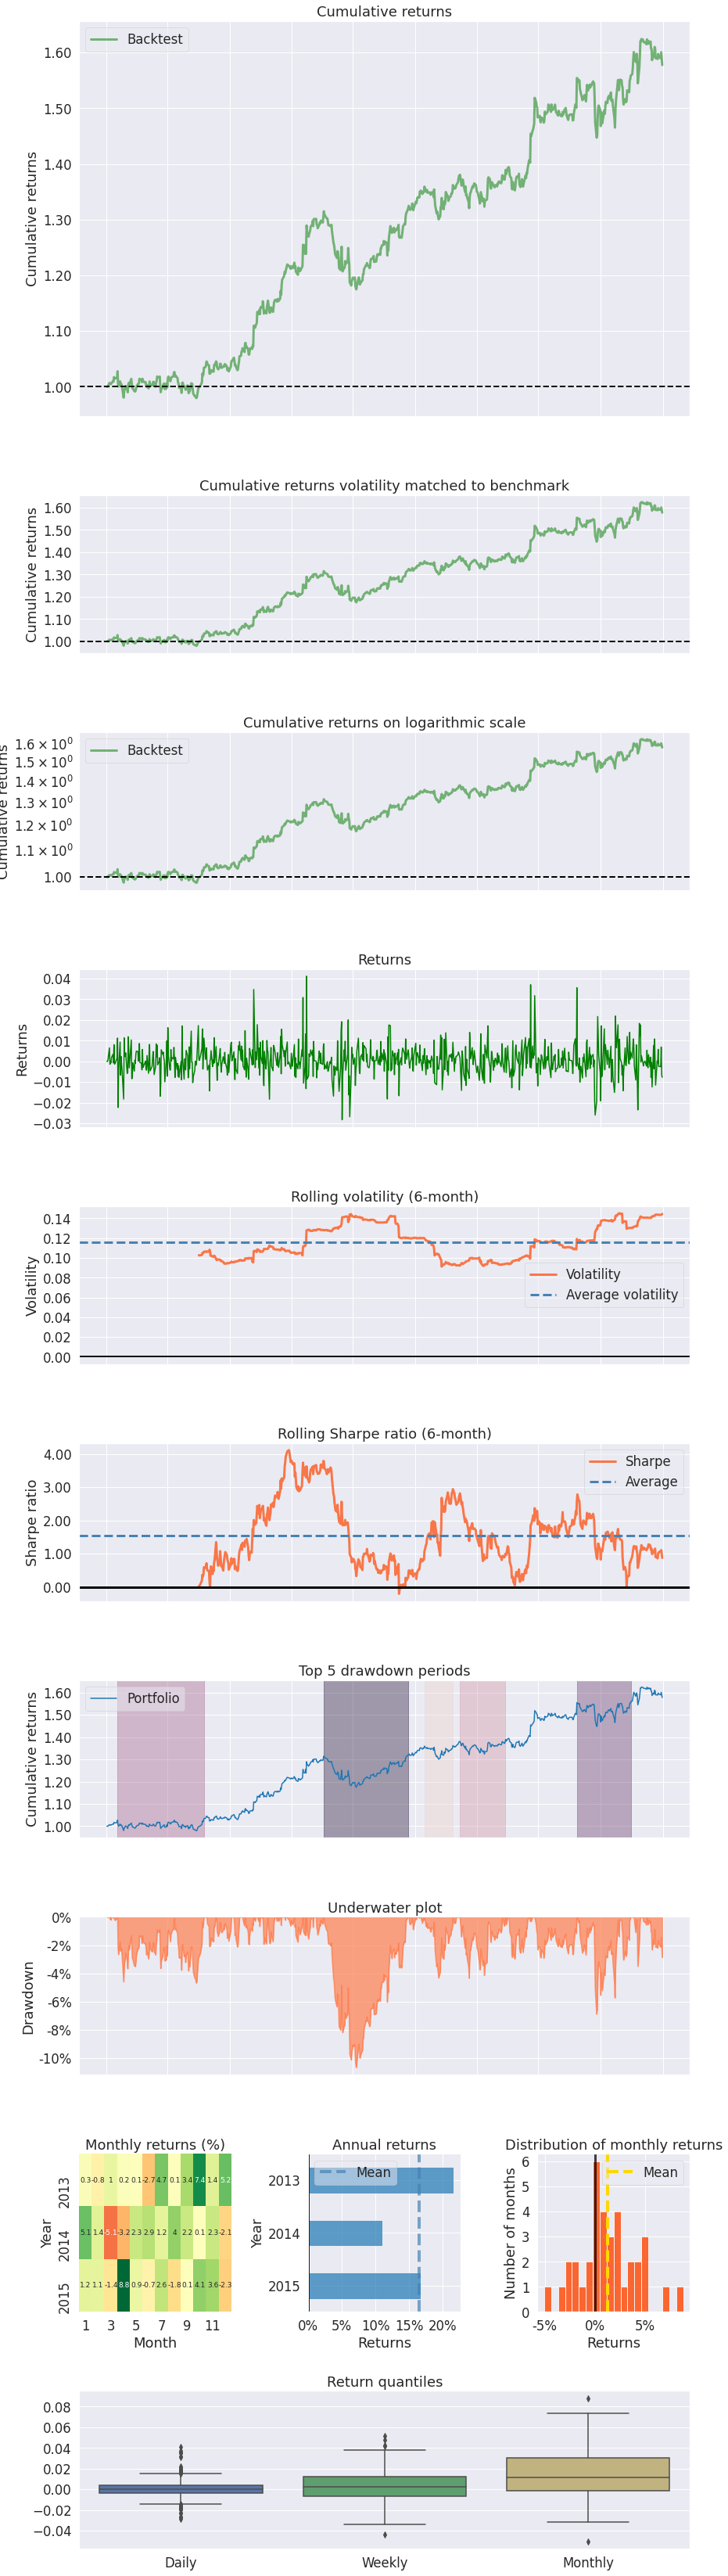

In [112]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

The strategy averaged 16.4% annual returns. From the cumulative returns plot we can see that the strategy generated quite strong positive returns over the entire trading period. The strategy has an average sharpe ratio of 1.6, quite consistently above 1. The max drawdown was 11% and the longest duration drawdown was 123 days, not bad at all considering the stable upwards trajectory. All in all, the better performing strategy.

Note that the data is from 2013 - 2015. However, I did clearly specify the start and end dates as 2015 and 2018, respectively. This issue persists even if I re-run the cell.

Because the time periods of the two backtests are different–as one includes the financial crisis, quite significantly so–comparison on the basis of performance is quite unfair in this circumstance. However, I can confidently say that I would prefer to trade with the ADX-SAR strategy during 2013-2015, over using MACD from 2006-2012:
The returns came quicker and larger, the drawdowns where smaller and less extreme. Thus, from both a financial and psychological perspective, I would prefer to ADX-SAR 2013-2015.

Note: both backtests exclude trade costs. I understand from Taha we will be adding this in during class.